# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">11:15-12:45, 1:15-</span>
* 2. Part B: <span style="color:red;">1 hour</span>
* 3. Part C: <span style="color:red;">4 hours...</span>
* 4. Part D: <span style="color:red;">4 hours</span>
* 5. Write-up: <span style="color:red;">15 min</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

In [1]:
# get all the imports done from the beginning
import numpy as np
import scipy
from imageio import imread
import cv2 as cv
from matplotlib import pyplot as plt
from numpy import linalg as la

# set up the plot sizes
plt.rcParams['figure.figsize'] = [16,16]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

In [2]:
# import the desired files
def importfiles(*arg):
    img = []    
    for num,file in enumerate(arg):
        print("file"+str(num)+": {}".format(file))
        img.append(imread(file))
    return img    

In [3]:
campusimages = importfiles("images/campus1.jpg","images/campus2.jpg","images/campus3.jpg")
np.shape(campusimages[0])

file0: images/campus1.jpg
file1: images/campus2.jpg
file2: images/campus3.jpg


(5312, 2988, 3)

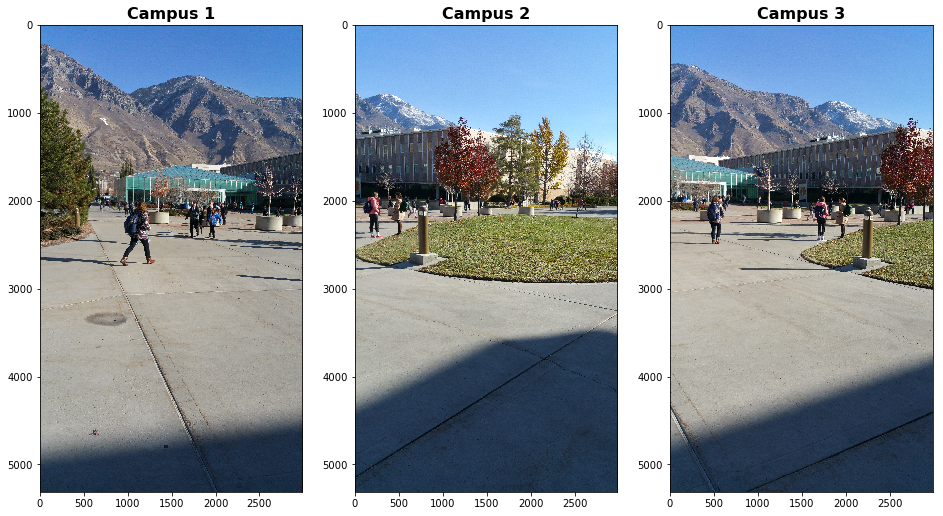

In [4]:
plt.subplot(131)
plt.imshow(campusimages[0])
plt.title("Campus 1")
plt.subplot(132)
plt.imshow(campusimages[1])
plt.title("Campus 2")
plt.subplot(133)
plt.imshow(campusimages[2])
plt.title("Campus 3")
plt.show()

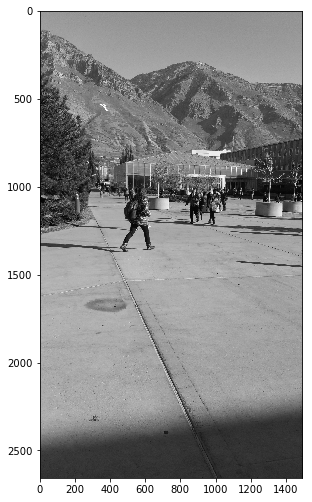

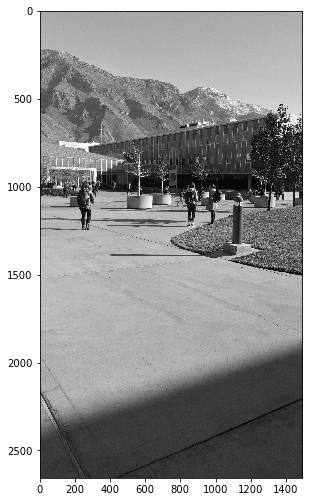

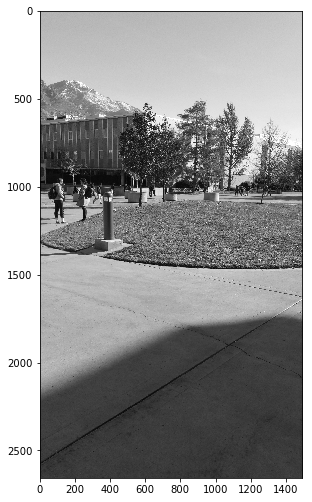

In [5]:
inImg0 = campusimages[0]
img = cv.resize(inImg0, (int(np.shape(inImg0)[1]*.5),int(np.shape(inImg0)[0]*.5))) 
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
keypoints = sift.detect(gray,None)
kp, des = sift.detectAndCompute(gray,None)

inImg1 = campusimages[2]
img1 = cv.resize(inImg1, (int(np.shape(inImg1)[1]*.5),int(np.shape(inImg1)[0]*.5))) 
gray1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
keypoints1 = sift.detect(gray1,None)
kp1, des1 = sift.detectAndCompute(gray1,None)

inImg2 = campusimages[1]
img2 = cv.resize(inImg2, (int(np.shape(inImg2)[1]*.5),int(np.shape(inImg2)[0]*.5))) 
gray2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
keypoints2 = sift.detect(gray2,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

plt.subplot(131)
plt.imshow(gray,cmap="gray")
plt.show()

plt.subplot(132)
plt.imshow(gray1,cmap="gray")
plt.show()

plt.subplot(133)
plt.imshow(gray2,cmap="gray")
plt.show()

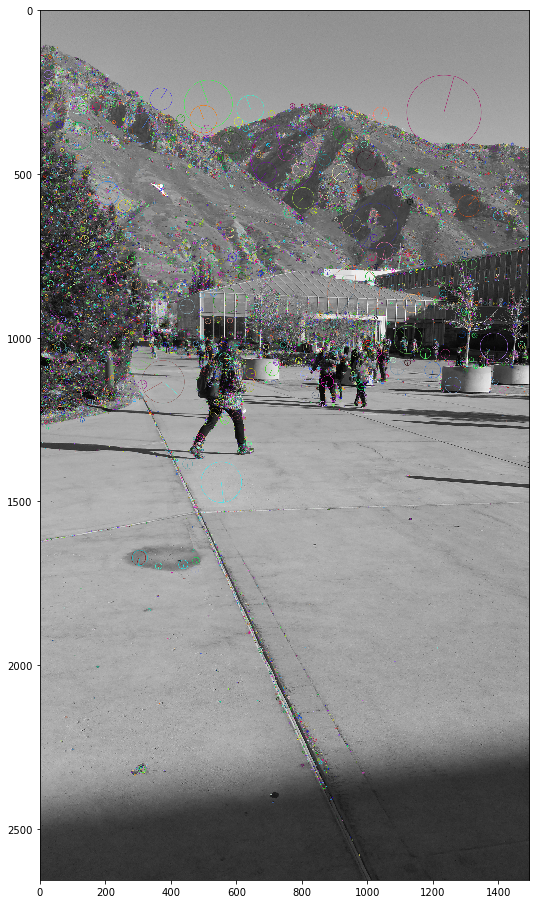

In [6]:
img_odd = cv.drawKeypoints(gray,keypoints,gray,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_odd,cmap="gray")
plt.show()

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

In [7]:
# # for each point in des1, find it's closest match in des2, and visa versa
# def find_matches(des1,des2):
#     '''Attributes:
#             des1: a list of the first descriptors
#             des2: a list of the second descriptors
            
#        Returns:
#             a list that matches the highest index from des2 to des1'''

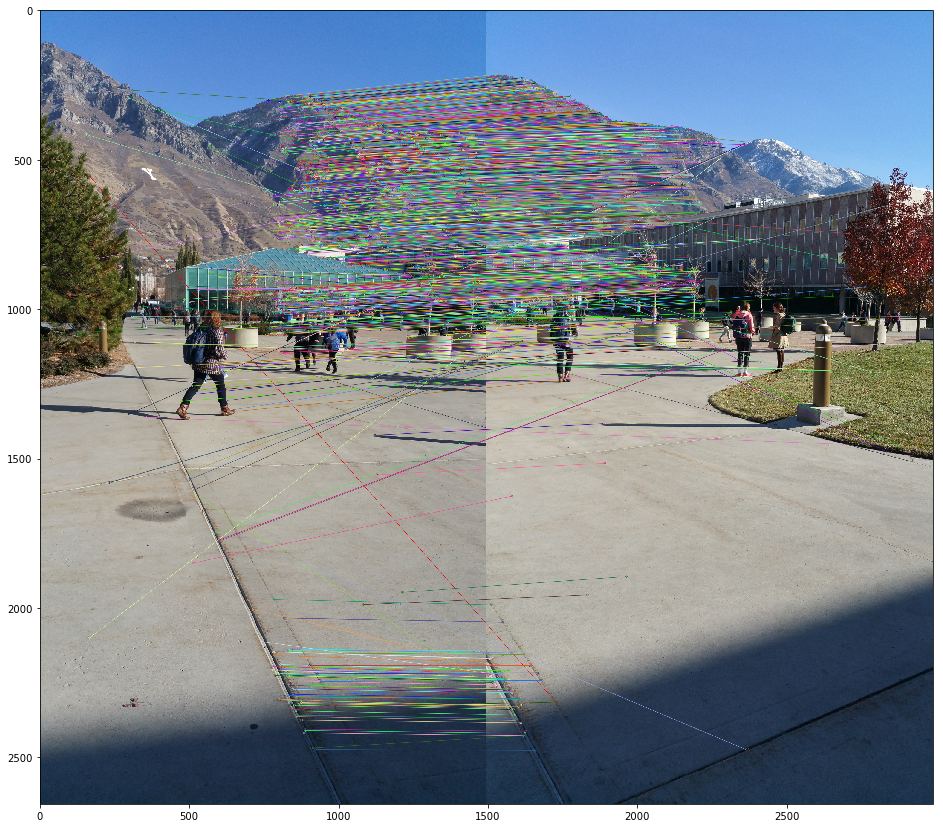

In [8]:

def creatematches(im1,im2,kp1,kp2,des1,des2):
    '''image, points, and descriptors for image 1 and 2'''
    bf = cv.BFMatcher()  # BFMatcher with default params
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    img = cv.drawMatches(im1,kp1,im2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img);plt.show()
    return good
    
goodmatches1 = creatematches(img,img1,kp,kp1,des,des1)

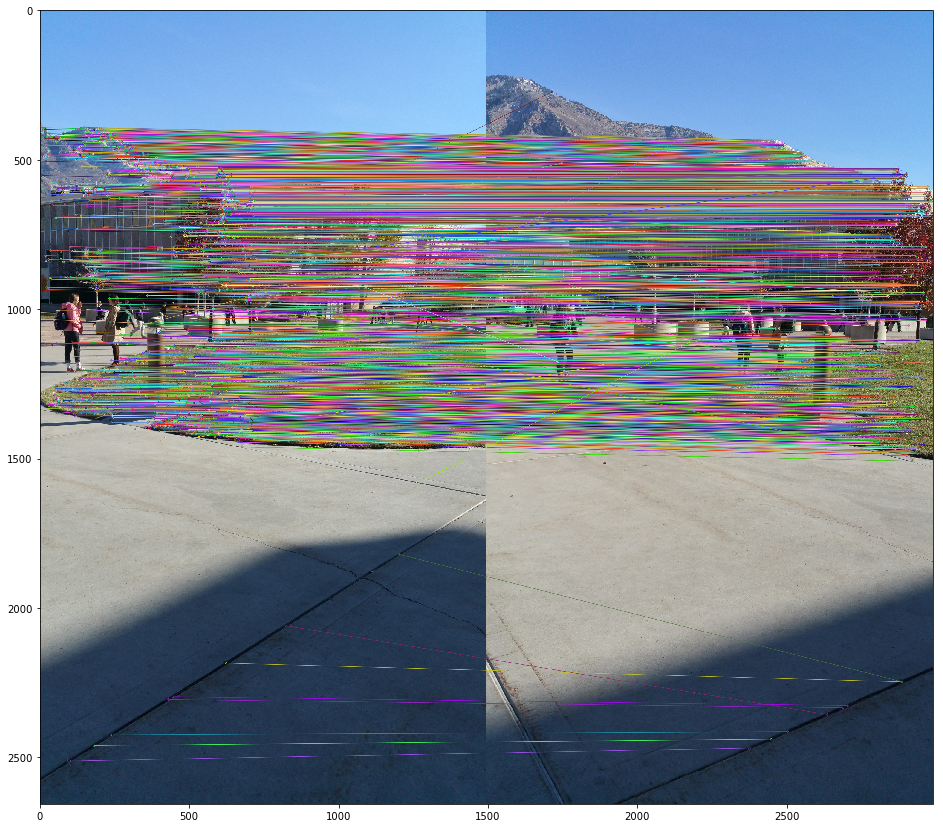

In [9]:
goodmatches2 = creatematches(img2,img1,kp2,kp1,des2,des1)

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

In [10]:
def createhomomatrix(matches,kp,kp1):
    '''creates a fesable homography matrix.  Returns false if a singular matrix is encountered.'''

    random_pt1 = int(np.random.random()*len(matches))
    random_pt2 = int(np.random.random()*len(matches))
    random_pt3 = int(np.random.random()*len(matches))
    random_pt4 = int(np.random.random()*len(matches))

    # establish the randomly selected values
    a1 = kp[matches[random_pt1].queryIdx].pt
    a2 = kp1[matches[random_pt1].trainIdx].pt
    b1 = kp[matches[random_pt2].queryIdx].pt
    b2 = kp1[matches[random_pt2].trainIdx].pt
    c1 = kp[matches[random_pt3].queryIdx].pt
    c2 = kp1[matches[random_pt3].trainIdx].pt
    d1 = kp[matches[random_pt4].queryIdx].pt
    d2 = kp1[matches[random_pt4].trainIdx].pt

    
    
    # set up the matrix to compute the homography values
    try: 
        A = np.matrix([
            [a1[0],a1[1],1,0,0,0,-a2[0]*a1[0], -a2[0]*a1[1]],
            [0,0,0,a1[0],a1[1],1,-a2[1]*a1[0], -a2[1]*a1[1]],
            [b1[0],b1[1],1,0,0,0,-b2[0]*b1[0], -b2[0]*b1[1]],
            [0,0,0,b1[0],b1[1],1,-b2[1]*b1[0], -b2[1]*b1[1]],
            [c1[0],c1[1],1,0,0,0,-c2[0]*c1[0], -c2[0]*c1[1]],
            [0,0,0,c1[0],c1[1],1,-c2[1]*c1[0], -c2[1]*c1[1]],
            [d1[0],d1[1],1,0,0,0,-d2[0]*d1[0], -d2[0]*d1[1]],
            [0,0,0,d1[0],d1[1],1,-d2[1]*d1[0], -d2[1]*d1[1]]])

        # set up the vector b to compute the homography values
        b = np.matrix([a2[0], a2[1],
                       b2[0], b2[1],
                       c2[0], c2[1],
                       d2[0], d2[1]])

        solutions = np.linalg.solve(A,b.reshape(-1,1))
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            return False
            
    # TODO: numpy.linalg.lstsq()

    return np.squeeze(np.asarray(solutions))
        
        
def find_best_homography(matches,kp,kp1):
    ''' finds the best homography after multiple consensus steps.  Requires points to be within a threshhold of 4.  
    Handles a False statement if given by createhomomatrix.'''
    n = len(matches)
    threshold = 4  # requires the euclidean distance between homography points to be within this threshold.
    n_consensus_steps = 80
    
    options = []
    for i in range(n_consensus_steps):
        solutions = False
        while solutions is False:  # handles the singular matrix problem- createhomomatrix returns False if a singular matrix is created.
            solutions = createhomomatrix(matches,kp,kp1)
        a,b,c,d,e,f,g,h = solutions
        
        inpoints = []
        for i in range(n):
            xs,ys = kp[matches[i].queryIdx].pt
            xt = (a*xs + b*ys + c)/(g*xs + h*ys +1)
            yt = (d*xs + e*ys + f)/(g*xs + h*ys +1)
            comp1, comp2 = kp1[matches[i].trainIdx].pt
            if np.sqrt((comp1-xt)**2+(comp2-yt)**2) <= threshold:
                inpoints.append((xt,yt))
        options.append([solutions,inpoints])
        #  options is of the form [[solution points],[all inpoints of form (x,y)]]
    
    maxcount, argmax = 0,0
    for i in range(n_consensus_steps):
        if len(options[i][1])>maxcount:
            maxcount = len(options[i][1])
            argmax = i
    best_homography = options[argmax][0]          
    best_homography = np.append(best_homography,1).reshape((3,3))        
    return best_homography

def goodH(kp1,kp2,matches):
    '''Serves as a comparison.  Gives the 'best'  homography for the points and matches.'''
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    return M


In [11]:
homography1 = find_best_homography(goodmatches1,kp,kp1)
homography2 = find_best_homography(goodmatches2,kp2,kp1)

In [12]:
# a,b,c,d,e,f,g,h = x
      
# for i in range(len(good)):
#     xs,ys = kp[good[i].queryIdx].pt
#     xt = (a*xs + b*ys + c)/(g*xs + h*ys +1)
#     yt = (d*xs + e*ys + f)/(g*xs + h*ys +1)
#     comp1, comp2 = kp1[good[i].trainIdx].pt
#     if np.sqrt((comp1-xt)**2+(comp2-yt)**2) <= 4:
#         print("({},{})\n({},{})".format(xt,yt,comp1,comp2))

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

In [13]:
def warp(xs,ys,warp_matrix):
    '''returns the warped coordinates of xs and ys'''
    a,b,c,d,e,f,g,h,_ = warp_matrix.flatten()
    xt = (a*xs + b*ys + c)/(g*xs + h*ys +1)
    yt = (d*xs + e*ys + f)/(g*xs + h*ys +1)
    return (xt,yt)

def get_bounding_rect(M, w, h):
    '''Returns the bounding rectangle of an image of width w and height h under transformation matrix M.'''
    return cv.boundingRect(np.array([warp(0,0,M),warp(w,0,M),warp(0,h,M),warp(w,h,M)]).astype(int))
    
    

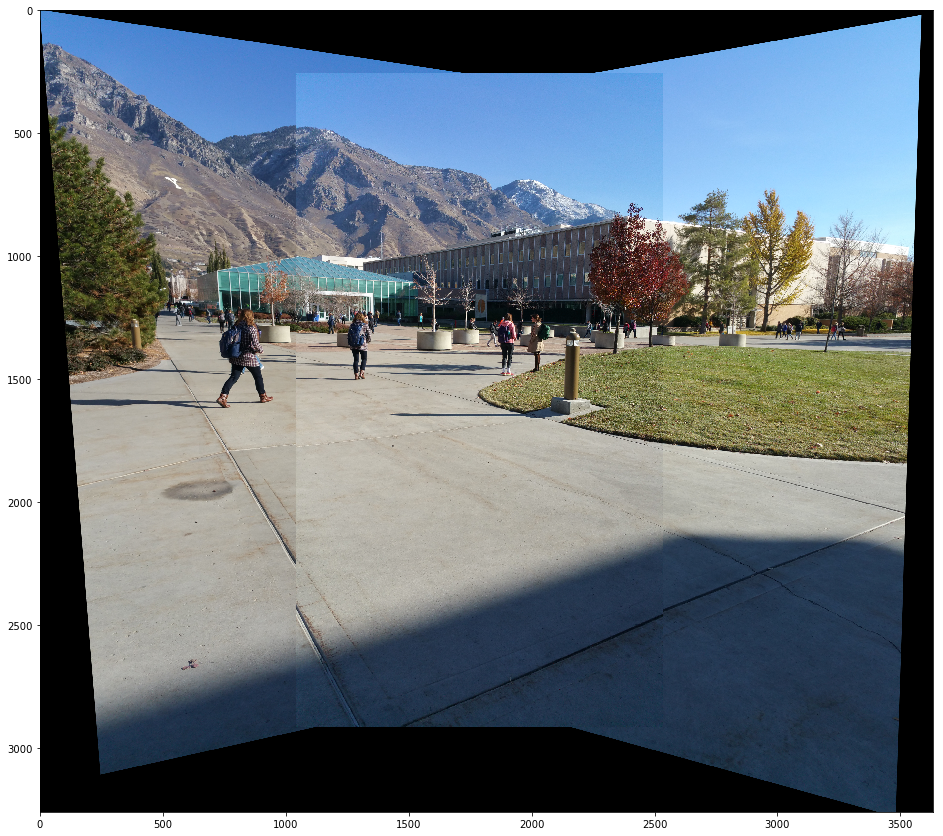

In [14]:
height1,width1,_ = np.shape(img)
height2,width2,_ = np.shape(img1)

homographies = [homography1,np.eye(3),homography2]
xs = []
ys = []
heights = []
widths = []
for H in homographies:
    x,y,w,h = get_bounding_rect(H,width1,height1)
    xs.append(x)
    ys.append(y)
    widths.append(w)
    heights.append(h)
    
boxheight = np.max(heights)
boxwidth = (np.max(xs) + np.max(widths)) - np.min(xs)
      
T = np.array([[1,0,-np.min(xs)],
              [0,1,-np.min(ys)],
              [0,0,          1]])

image1 = cv.warpPerspective(img,T @ homographies[0],(boxwidth,boxheight))
base = cv.warpPerspective(img1,T@ homographies[1],(boxwidth,boxheight))
image3 = cv.warpPerspective(img2,T@ homographies[2],(boxwidth,boxheight))

image1[image3 != np.array([0,0,0])] = 0
image1[base != np.array([0,0,0])] = 0

image3[image1 != np.array([0,0,0])] = 0
image3[base != np.array([0,0,0])] = 0

base[image3 != np.array([0,0,0])] = 0
base[image1 != np.array([0,0,0])] = 0

combined1 = np.uint8(np.where(base == np.array([0,0,0]) , image3*.33, base*.33 + image1*.33))
combined2 = np.uint8(np.where(base == np.array([0,0,0]) , image1*.33, base*.33 + image3*.33))
combined3 = np.uint8(np.where(image3 == np.array([0,0,0]) , base*.33, image3*.33 + image1*.33))

combined_total = image1+base+image3
                             
# plt.subplot(311)
# plt.imshow(image1)
# plt.show()        
# plt.subplot(312)
# plt.imshow(base) 
# plt.show()         
# plt.subplot(313)
# plt.imshow(image3)                              
# plt.show()
plt.imshow(combined_total)
plt.show()



### Part A: Find Interest Points/Descriptors

In [15]:
# Place Code Here
# Show an example output here

# import the desired files
def importfiles(*arg):
    """imports image files given the filenames as arguments.
    Returns a list of the images."""
    percent = .25 # scaling percentage for images
    images = []    
    for num,file in enumerate(arg):
        print("file"+str(num)+": {}".format(file))
        images.append(imread(file))
    for num,img in enumerate(images):
        inImg0 = img
        images[num] = cv.resize(inImg0, (int(np.shape(inImg0)[1]*percent),int(np.shape(inImg0)[0]*percent))) # rescale the image down to 
                                                                                                     # a percent of it's origional value
    return images  

campusimages = importfiles("images/campus1.jpg","images/campus2.jpg","images/campus3.jpg")
imagelist = [i for i in campusimages]

file0: images/campus1.jpg
file1: images/campus2.jpg
file2: images/campus3.jpg


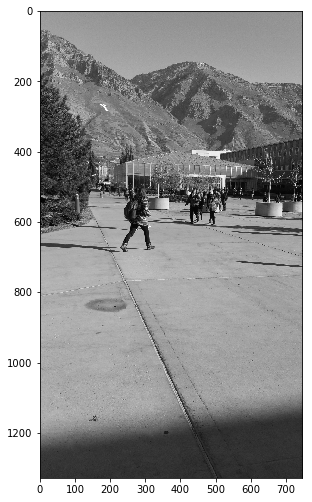

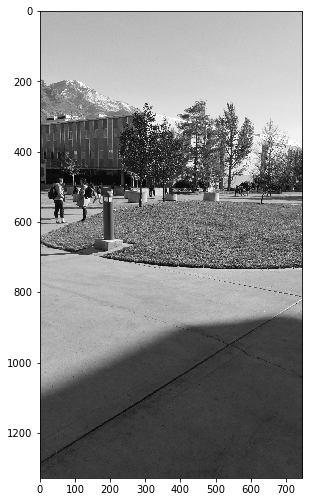

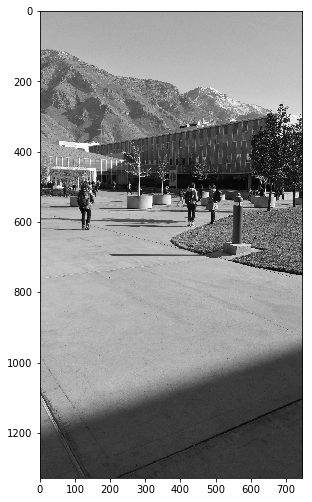

In [16]:
def keypoints_and_descriptors(imlist):
    """Takes in images, and returns a tuple of keypoint and descriptor lists, in the order
    ([img1keypoints,image2keypoints,...],[img1descriptors,img2descriptors,...])"""
    
    keylist = []
    descriptionlist = []
    n = len(imlist)
    for i in range(n):
        image = imlist[i]
        gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        sift = cv.xfeatures2d.SIFT_create()
        keypoints = sift.detect(gray,None)
        kp, des = sift.detectAndCompute(gray,None)
        keylist.append(kp)
        descriptionlist.append(des)

        plt.subplot(131)
        plt.imshow(gray,cmap="gray")
        plt.show()
    
    return keylist,descriptionlist

kpoints,descrips = keypoints_and_descriptors(campusimages)

### Part B: Matching Features

See above, beneath the "Part B" explanation.

### Part C: Estimating Pairwise Homographies using RANSAC

See above, beneath the "Part C" explanation.

### Part D: Creating the Mosaic

See above, beneath the "Part D" explanation.

### Final Results and Improvements

I was able to create a good final stitching, and added an alpha mask on top in order to show the images at their full brightness.  

### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.

In [17]:
It was hard to get good allignment when the image had too few points of interest to create a good homography.

SyntaxError: invalid syntax (<ipython-input-17-0256c4b0b801>, line 1)